# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Advanced Lane Finding


---
## Camera Calibration

Using different images of chessboard and openCV library, we can calibrate the camera and get the calibration parameters to correct test images and video frames

In [1]:
import numpy as np
import cv2
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
calib_images = []
gray_calib_images = []

calib_samples = glob.glob('camera_cal/*.jpg')

for sample in calib_samples:
    img = cv2.imread(sample)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    calib_images.append(img)
    gray_calib_images.append(gray)

    

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

index = 16 #random.randint(0,len(calib_images))

for idx in range(len(calib_images)):

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray_calib_images[idx], (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        if index == idx:
            plt.figure(figsize=(6, 6))
            img = cv2.drawChessboardCorners(calib_images[idx], (9,6), corners,ret)
            plt.imshow(img)
            plt.show()


### Camera Calibration Parameters

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_calib_images[0].shape[::-1],None,None)

### Correct Distorted Image

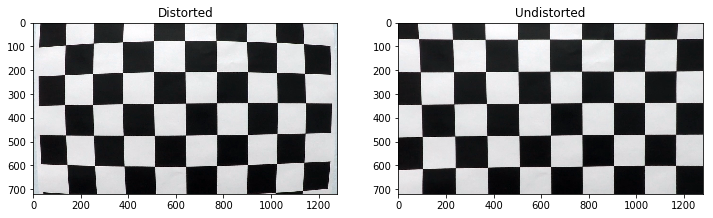

In [3]:
undist_img = cv2.undistort(calib_images[index], mtx, dist, None, mtx)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.title('Distorted')
plt.imshow(calib_images[index])
plt.subplot(1,2,2)
plt.title('Undistorted')
plt.imshow(undist_img)
plt.savefig('output_images/Distorted_Undistorted.jpg', bbox_inches='tight')
plt.show()

---
## Lane Finding Pipeline

### Select Color Space

First, we will analyze different color spaces (RGB & HLS) to find the lane lines in images and video frames

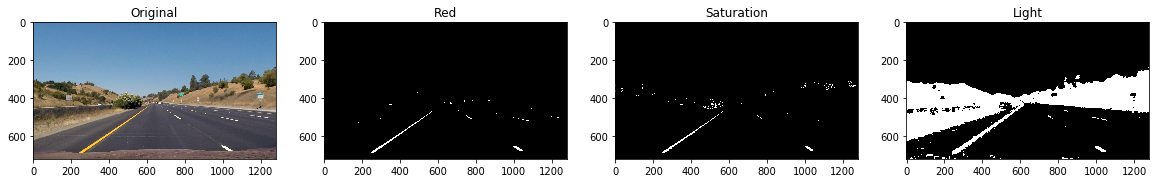

In [352]:
import matplotlib.image as mpimg

test_samples = glob.glob('test_images/*.jpg')

index = random.randint(0,len(test_samples))

image = mpimg.imread(test_samples[index])

plt.figure(figsize = (20,15))
plt.subplot(1,4,1)
plt.title('Original')
plt.imshow(image)

R = image[:,:,0]
thresh = (220, 255)
R_binary = np.zeros_like(R)
R_binary[(R > thresh[0]) & (R <= thresh[1])] = 1
plt.subplot(1,4,2)
plt.title('Red')
plt.imshow(R_binary, cmap='gray')

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
S = hls[:,:,2]
thresh = (180, 255)
S_binary = np.zeros_like(S)
S_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.subplot(1,4,3)
plt.title('Saturation')
plt.imshow(S_binary, cmap='gray')
    
L = hls[:,:,0]
thresh = (10, 40)
L_binary = np.zeros_like(L)
L_binary[(L > thresh[0]) & (L <= thresh[1])] = 1
plt.subplot(1,4,4)
plt.title('Light')
plt.imshow(L_binary, cmap='gray')
plt.savefig('output_images/Color_Space.jpg', bbox_inches='tight')

plt.show()

### Select Gradient

Here, we will check the gradient effect in the x direction, y direction, x_y direction and angle direction

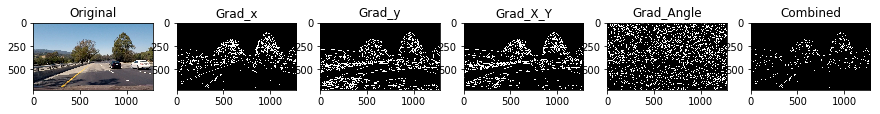

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Apply Gradient in x or y direction
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F , 1, 0, ksize= sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F , 0, 1, ksize= sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh_min = 20
    thresh_max = 100
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary

# Apply Gradient in x_y direction
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F , 1, 0, ksize= sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F , 0, 1, ksize= sobel_kernel)
    # 3) Calculate the magnitude 
    sobel = ((sobelx*sobelx) + (sobely*sobely))**0.5
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Apply gradient in angle direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F , 1, 0, ksize= sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F , 0, 1, ksize= sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelx = (sobelx*sobelx)**0.5
    abs_sobely = (sobely*sobely)**0.5
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grid = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_grid)
    binary_output[(dir_grid >= thresh[0]) & (dir_grid <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


ksize = 5

index = random.randint(0,len(test_samples))

image = mpimg.imread(test_samples[index])

plt.figure(figsize = (10,10))
    
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 120))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 120))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 120))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(np.pi/8, np.pi/4))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
# Plot the gradient effect for x, y, x_y, angle directions 
plt.figure(figsize=(15,15))
plt.subplot(1,6,1)
plt.title('Original')
plt.imshow(image)
plt.subplot(1,6,2)
plt.title('Grad_x')
plt.imshow(gradx, cmap='gray')
plt.subplot(1,6,3)
plt.title('Grad_y')
plt.imshow(grady, cmap='gray')
plt.subplot(1,6,4)
plt.title('Grad_X_Y')
plt.imshow(mag_binary, cmap='gray')
plt.subplot(1,6,5)
plt.title('Grad_Angle')
plt.imshow(dir_binary, cmap='gray')
plt.subplot(1,6,6)
plt.title('Combined')
plt.imshow(combined, cmap='gray')
    
plt.show()
    

However the gradient in the x direction is the best of them but it won't be used as it's not as good as the results from color space check 

In [359]:
def pipeline(image):
    
    img = np.copy(image)
    
    lower = np.uint8([  0,   0, 220])
    upper = np.uint8([  0,   0, 255])
    red_mask = cv2.inRange(img, lower, upper)
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hls, lower, upper)
    
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(hls, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    
    combined_binary = cv2.bitwise_and(image, image, mask = mask)
    
    combined_binary = cv2.cvtColor(combined_binary, cv2.COLOR_RGB2GRAY).astype(np.float)/255
    
    return combined_binary
    

### Test Pipeline

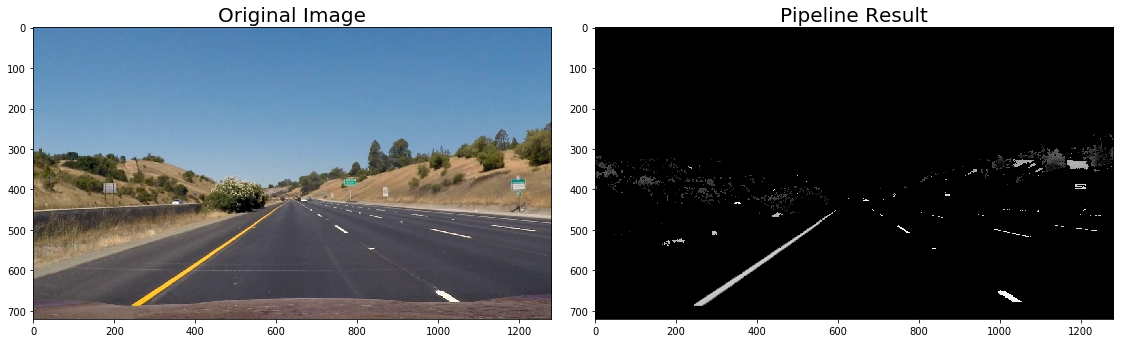

In [379]:
index = random.randint(0,len(test_samples))

image = mpimg.imread(test_samples[index])
    
image = mpimg.imread(file)

result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
f.tight_layout()

ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/Pipeline_result.jpg', bbox_inches='tight')    
plt.show()

---
## Perspective Transform

### Define source and destination points

In [358]:
# Define source points
src = np.float32([[0.156*img_shape[1], img_shape[0]],
                  [0.458*img_shape[1], 0.632*img_shape[0]],
                  [0.548*img_shape[1], 0.632*img_shape[0]],
                  [0.882*img_shape[1], img_shape[0]]])



#src = np.float32([[0.156*img_shape[1], img_shape[0]],
#                  [0.365*img_shape[1], 0.75*img_shape[0]],
#                  [0.66*img_shape[1], 0.75*img_shape[0]],
#                  [0.882*img_shape[1], img_shape[0]]])
#

# Define Destination points
dst = np.float32([[0.25*img_shape[1], src[0][1]], 
                  [0.25*img_shape[1], 0], 
                  [0.765*img_shape[1], 0], 
                  [0.765*img_shape[1], src[3][1]]])


# Valculate the transformation matrix and the inverse of this matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)


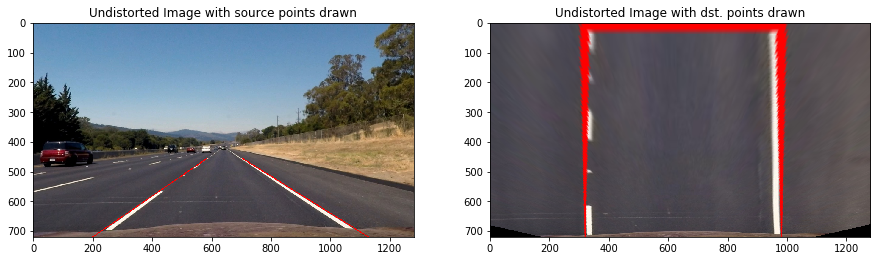

In [376]:
img_shape = mpimg.imread(test_samples[0]).shape

index = random.randint(0,len(test_samples)-1)

image = mpimg.imread(test_samples[index])

image = cv2.undistort(image, mtx, dist, None, mtx)

cv2.line(image,(src[0][0],src[0][1]),(src[1][0],src[1][1]),(255,0,0),2)   
cv2.line(image,(src[1][0],src[1][1]),(src[2][0],src[2][1]),(255,0,0),2)
cv2.line(image,(src[2][0],src[2][1]),(src[3][0],src[3][1]),(255,0,0),2)
cv2.line(image,(src[3][0],src[3][1]),(src[0][0],src[0][1]),(255,0,0),2)

warped = cv2.warpPerspective(image, M, (img_shape[1],img_shape[0]), flags=cv2.INTER_LINEAR)

plt.figure(figsize = (15,10))

plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Undistorted Image with source points drawn")
plt.subplot(1,2,2)
plt.title("Undistorted Image with dst. points drawn")
plt.imshow(warped)
plt.savefig('output_images/Perspective_Transform.jpg', bbox_inches='tight')
plt.show()


### Test Perspective Transform and Pipeline on Test Images

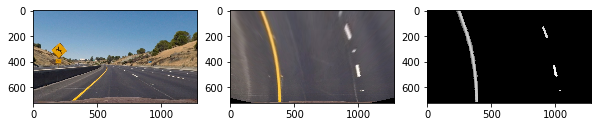

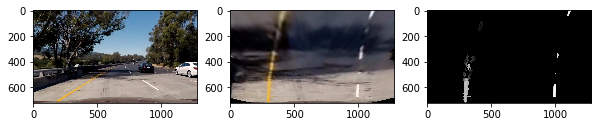

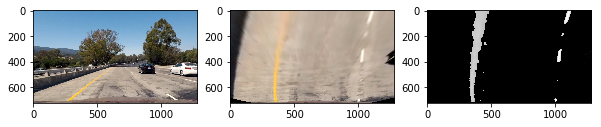

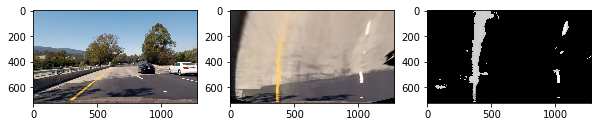

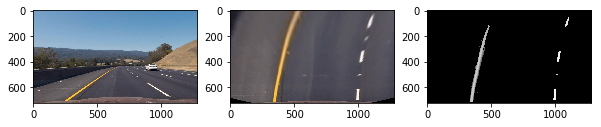

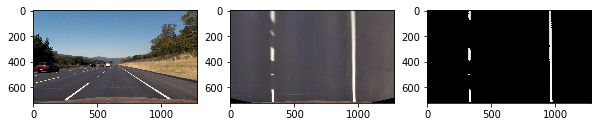

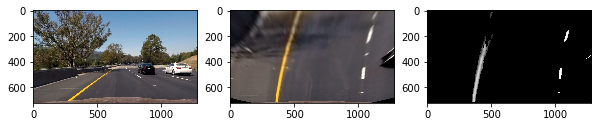

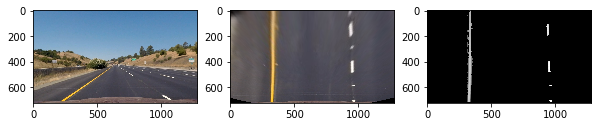

In [345]:
for file in test_samples:
    
    img = mpimg.imread(file)
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    warped = cv2.warpPerspective(img, M, (img_shape[1],img_shape[0]), flags=cv2.INTER_LINEAR)
    
    grad_img = pipeline(warped)
    
    plt.figure(figsize = (10,8))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(warped)
    plt.subplot(1,3,3)
    plt.imshow(grad_img, cmap='gray')
    plt.show()

---
## Find Lane Lines

In [374]:
def find_lane_lines(img, vis = False):
    
    # Use camera calibration matrix to undistort the image
    img = cv2.undistort(img, mtx, dist, None, mtx)    
    
    # Apply perspective transformation
    warped = cv2.warpPerspective(img, M, (img_shape[1],img_shape[0]), flags=cv2.INTER_LINEAR)
    
    # Apply
    binary_warped = pipeline(warped)
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        if vis == True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,0,1), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 3)
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval_right = np.max(righty*ym_per_pix)
    y_eval_left = np.max(lefty*ym_per_pix)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    lane_center_shift = (((rightx_base + leftx_base)/2) - (img.shape[1]/2)) * xm_per_pix
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]  
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
        
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(np.copy(img), 1, newwarp, 0.3, 0)
        
    cv2.putText(result, str("Radius of Curvature is: " + str(int((left_curverad+right_curverad)/2)) + "m"),
                (100,50), 50, 1,(255,255,255),2,cv2.LINE_AA)
    
    if lane_center_shift < 0:
        cv2.putText(result, str("Vehicle is: " + str(round(-lane_center_shift)) + " m left of center"),
                    (100,100), 50, 1,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(result, str("Vehicle is: " + str(round(lane_center_shift,2)) + " m right of center"),
                   (100,100), 50, 1,(255,255,255),2,cv2.LINE_AA)
        
    if vis == True:
        
        plt.figure(figsize = (15,10))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('output_images/lane_lines.jpg', bbox_inches='tight')  
        plt.show()
    
    return result
    

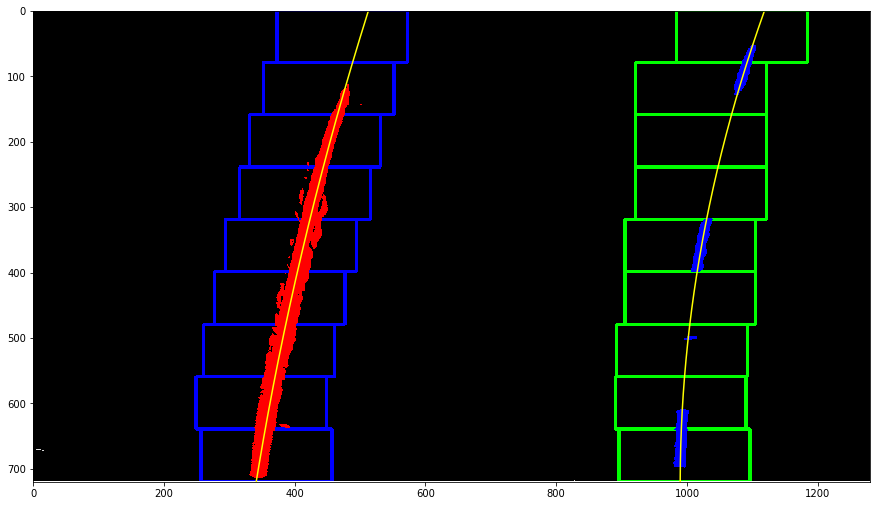

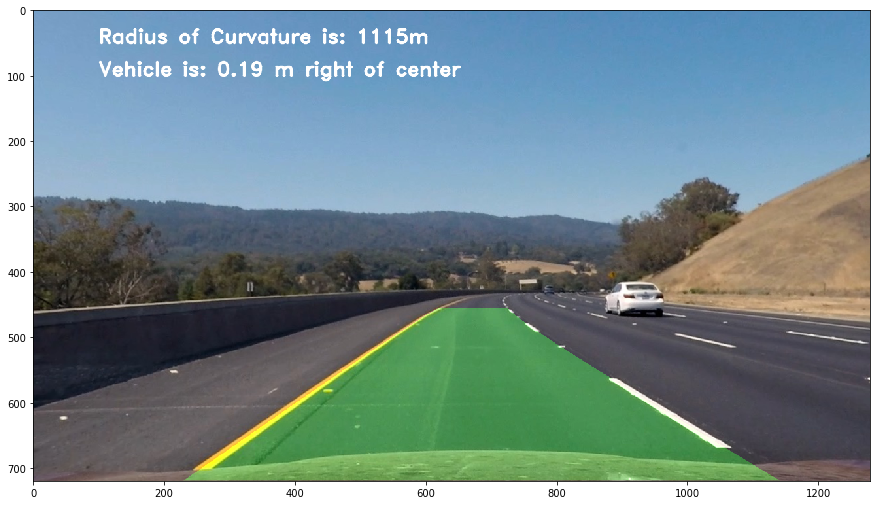

In [375]:
index = random.randint(0,len(test_samples)-1)

img = mpimg.imread(test_samples[index])
    
result = find_lane_lines(img, vis = True)

plt.figure(figsize = (15,10))
plt.imshow(result)
plt.savefig('output_images/Road_Curvature.jpg', bbox_inches='tight')  
plt.show()

## Video implementation

In [339]:
class find_lane:
    
    def __init__(self):
        self.no_frames = 10
        self.current_frame = -1
        self.right_curverad = []
        self.left_curverad = []
        self.left_fitx = []
        self.right_fitx = []
    
    def find_lane_lines(self,img):
            
        img = cv2.undistort(img, mtx, dist, None, mtx)
        
        warped = cv2.warpPerspective(img, M, (img_shape[1],img_shape[0]), flags=cv2.INTER_LINEAR)
    
        binary_warped = pipeline(warped, s_thresh=(135, 255), r_thresh=(90,130)) #135 150  120 255
    
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        if(leftx.size == 0 or rightx.size == 0):
            return img
        
        if(self.current_frame < self.no_frames):
            self.current_frame = self.current_frame + 1
            
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        y_eval_right = np.max(righty*ym_per_pix)
        y_eval_left = np.max(lefty*ym_per_pix)
    
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        #print(left_curverad, 'm', right_curverad, 'm')
        
        if(self.current_frame == self.no_frames):
            self.right_curverad.pop(0)
            self.left_curverad.pop(0)
        
        self.right_curverad.append(right_curverad);
        self.left_curverad.append(left_curverad);        
    
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        if(self.current_frame == self.no_frames):
            self.left_fitx.pop(0)
            self.right_fitx.pop(0)
            
        self.left_fitx.append(left_fitx)
        self.right_fitx.append(right_fitx)
        
        leftx_base = np.mean(self.left_fitx, axis = 0)[len(np.mean(self.left_fitx, axis = 0)) - 1]
        rightx_base = np.mean(self.right_fitx, axis = 0)[len(np.mean(self.right_fitx, axis = 0)) - 1]
        
        lane_center_shift = (((rightx_base + leftx_base)/2) - (img.shape[1]/2)) * xm_per_pix 
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([np.mean(self.left_fitx, axis=0), ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([np.mean(self.right_fitx, axis=0), ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_zero, np.int_([pts]), (0,255,0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(warp_zero, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(np.copy(img), 1, newwarp, 0.3, 0)
        
        cv2.putText(result, str("Radius of Curvature is: " + str(int((np.average(self.left_curverad)+np.average(self.right_curverad))/2)) + "m"),
                    (100,50), 50, 1,(255,255,255),2,cv2.LINE_AA)
        
        if lane_center_shift < 0:
            cv2.putText(result, str("Vehicle is: " + str(round(-lane_center_shift)) + " m left of center"),
                    (100,100), 50, 1,(255,255,255),2,cv2.LINE_AA)
        else:
            cv2.putText(result, str("Vehicle is: " + str(round(lane_center_shift,2)) + " m right of center"),
                    (100,100), 50, 1,(255,255,255),2,cv2.LINE_AA)
    
        return result

In [350]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
del FL
FL = find_lane()

project_output = 'project_video_output.mp4'

#clip1 = VideoFileClip("project_video.mp4").subclip(0,20)

clip1 = VideoFileClip("project_video.mp4")

project_clip = clip1.fl_image(FL.find_lane_lines) #NOTE: this function expects color images!!

%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output_test.mp4
[MoviePy] Writing video harder_challenge_video_output_test.mp4


100%|█████████▉| 1199/1200 [04:33<00:00,  3.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output_test.mp4 

CPU times: user 6min 37s, sys: 3.23 s, total: 6min 40s
Wall time: 4min 35s
